<a href="https://colab.research.google.com/github/01675065117/Data-Analysis-Projects/blob/main/Google_Play_Store_App_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Play Store App Analysis

In [ ]:
# Importing the necessary modules
import pandas as pd
import numpy as np
import missingno as mnso
from sklearn import preprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multicomp as mc
import scipy.stats as stats
import statsmodels.formula.api as smf
%matplotlib inline
pd.set_option('display.max_columns', 100) # Show all columns when looking at dataframe
warnings.filterwarnings('ignore') # Ignore warnnings

In [ ]:
# Install "skimpy" package: This package allows you to clean column names  
!pip install skimpy
from skimpy import clean_columns

In [ ]:
# Install "pingouin" package: This package allows you to perform Welch's ANOVA test
!pip install pingouin
import pingouin as pg

In [ ]:
path_1 = "/content/drive/MyDrive/DATA/googleplaystore.csv"
path_2 = "/content/drive/MyDrive/DATA/googleplaystore_user_reviews.csv"
df_app = pd.read_csv(path_1)
df_reviews = pd.read_csv(path_2)

## GG_APP analysis

***Data Definition***

|Column|Definition|
|:---|:---|
|App|Application name|
|Category|Category the app belongs to|
|Rating|Overall user rating of the app (as when scraped)|
|Reviews|Number of user reviews for the app (as when scraped)|
|Size|Size of the app (as when scraped)|
|Installs|Number of user downloads/installs for the app (as when scraped)|
|Type|Paid or Free|
|Price|Price of the app (as when scraped)|
|Content Rating|Age group the app is targeted at - Children / Mature 21+ / Adult|
|Genres|An app can belong to multiple genres (apart from its main category). For eg, a musical family game will belong to Music, Game, Family|

In [ ]:
df_app.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Check duplicates and remove them.

In [ ]:
print(f'There are {df_app.duplicated().sum()} duplicated rows in the dataset.')

There are 483 duplicated rows in the dataset.


In [ ]:
original = df_app.shape
df_new =  df_app.drop_duplicates()
after_remove_duplicates = df_new.shape
print(f'Number of rows before remove duplicates: {original[0]}\nNumber of rows after remove duplicates: {after_remove_duplicates[0]}')

Number of rows before remove duplicates: 10841
Number of rows after remove duplicates: 10358


Check and fill NaN values.

In [ ]:
df_new.isna().sum()

App                  0
Category             0
Rating            1465
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [ ]:
# Cleaning all columns in "snake case style"
df_new = clean_columns(df_new)
df_new.columns

Index(['app', 'category', 'rating', 'reviews', 'size', 'installs', 'type',
       'price', 'content_rating', 'genres', 'last_updated', 'current_ver',
       'android_ver'],
      dtype='object')

In [ ]:
df_new = df_new.loc[~df_new['type'].isna(),:].copy()
df_new = df_new.loc[~df_new['android_ver'].isna(),:].copy()
df_new = df_new.loc[~df_new['current_ver'].isna(),:].copy()
df_new = df_new.loc[~df_new['content_rating'].isna(),:].copy()
df_new.isna().sum()

app                  0
category             0
rating            1460
reviews              0
size                 0
installs             0
type                 0
price                0
content_rating       0
genres               0
last_updated         0
current_ver          0
android_ver          0
dtype: int64

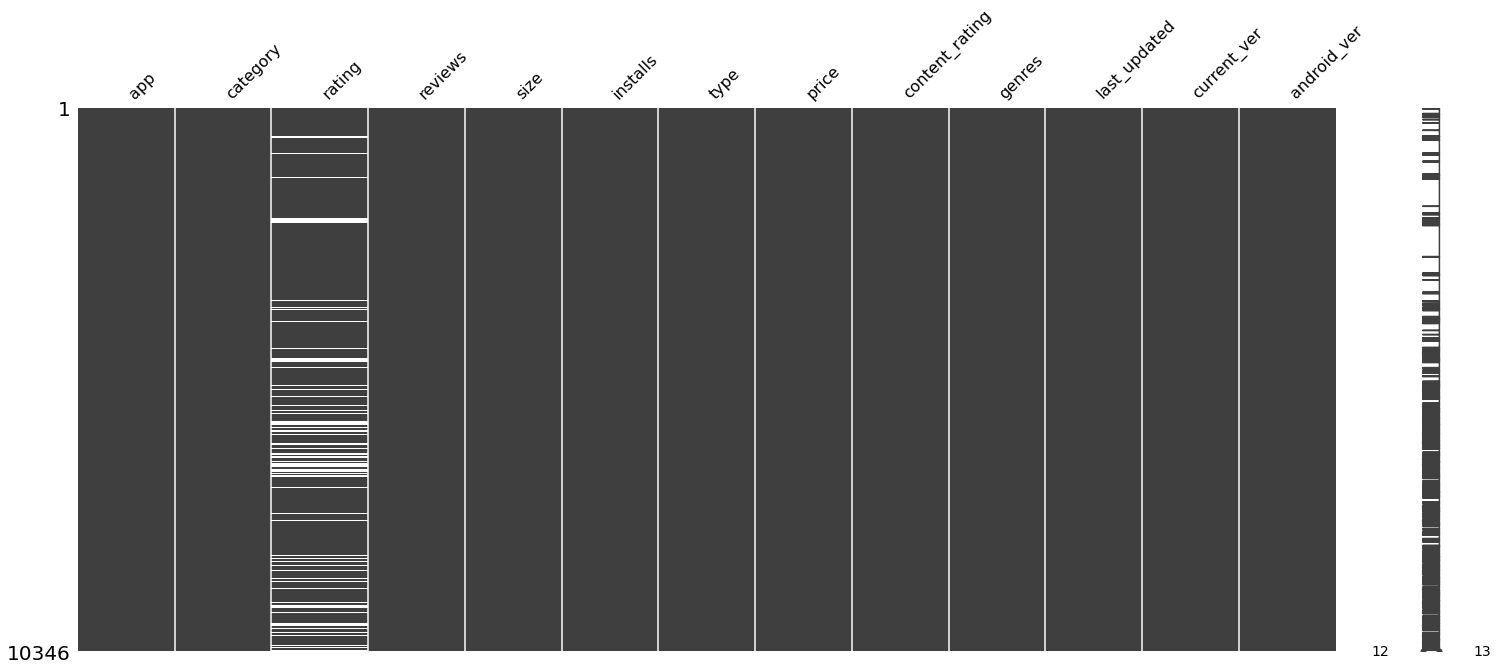

In [ ]:
mnso.matrix(df_new)

Using Interpolation to fill Missing Values

In [ ]:
df_new['rating'] = df_new['rating'].interpolate(method="linear")

In [ ]:
df_new.isna().sum()

app               0
category          0
rating            0
reviews           0
size              0
installs          0
type              0
price             0
content_rating    0
genres            0
last_updated      0
current_ver       0
android_ver       0
dtype: int64

Yeahhh, that's look great for now. There are no NaNs anymore.

In [ ]:
df_new['reviews'] = df_new['reviews'].astype(int)
df_new['reviews'].dtype

dtype('int64')

In [ ]:
df_new['installs'] = df_new['installs'].str.replace(r'+','')
df_new['installs'] = df_new['installs'].str.replace(r',','')
df_new['installs'] = df_new['installs'].astype(int)
df_new['installs'].dtype

dtype('int64')

**Clustering size column.**

I will replace:

*   'Varies with device' with -1
*   'k' with format '000'. Ex: 1k = 1000
*   'M' with format '000000'. Ex: 1M = 1000000

And seperate it into 5 categories


*   value < 1M: very_low
*   1M < value < 10M: low
*   10M < value < 20M: medium
*   20M < value < 50M: high
*   50M < value: very_high
*   -1: varies_with_device




In [ ]:
df_new['size']

0                       19M
1                       14M
2                      8.7M
3                       25M
4                      2.8M
                ...        
10836                   53M
10837                  3.6M
10838                  9.5M
10839    Varies with device
10840                   19M
Name: size, Length: 10346, dtype: object

In [ ]:
df_new['size'] = df_new['size'].str.replace(r'Varies with device','-1')
df_new['size'] = df_new['size'].replace({"k":"*1e3", "M":"*1e6"}, regex=True).map(pd.eval).astype(int)

In [ ]:
df_new.installs

0           10000
1          500000
2         5000000
3        50000000
4          100000
           ...   
10836        5000
10837         100
10838        1000
10839        1000
10840    10000000
Name: installs, Length: 10346, dtype: int64

In [ ]:
df_new['instgrp'] = pd.cut(df_new.installs, [-2, 0, 1000000, 20000000, 50000000, 100000000], 
                           labels=["varies_with_device", "low", "medium", "high", "very_high"])
df_new.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,instgrp
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,low
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,low
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,medium
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,high
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,low


In [ ]:
df_new['category'].value_counts()

FAMILY                 1939
GAME                   1121
TOOLS                   841
BUSINESS                427
MEDICAL                 408
PRODUCTIVITY            407
PERSONALIZATION         386
LIFESTYLE               373
COMMUNICATION           366
FINANCE                 360
SPORTS                  351
PHOTOGRAPHY             322
HEALTH_AND_FITNESS      306
SOCIAL                  280
NEWS_AND_MAGAZINES      264
TRAVEL_AND_LOCAL        237
BOOKS_AND_REFERENCE     229
SHOPPING                224
DATING                  196
VIDEO_PLAYERS           175
MAPS_AND_NAVIGATION     137
EDUCATION               130
FOOD_AND_DRINK          124
ENTERTAINMENT           111
AUTO_AND_VEHICLES        85
LIBRARIES_AND_DEMO       84
WEATHER                  82
HOUSE_AND_HOME           80
EVENTS                   64
ART_AND_DESIGN           64
PARENTING                60
COMICS                   60
BEAUTY                   53
Name: category, dtype: int64

In [ ]:
df_sorted = df_new[['app', 'category','reviews']]
df_sorted = df_sorted.sort_values(by = 'reviews', ascending=False)
df_sorted

,app,category,reviews
2544,Facebook,SOCIAL,78158306
3943,Facebook,SOCIAL,78128208
336,WhatsApp Messenger,COMMUNICATION,69119316
3904,WhatsApp Messenger,COMMUNICATION,69109672
2604,Instagram,SOCIAL,66577446
...,...,...,...
6176,Dete.bg,NEWS_AND_MAGAZINES,0
9329,EG Groups,EVENTS,0
9330,EG Way Life,SOCIAL,0
9333,qEG APP / Química EG SRL,TOOLS,0


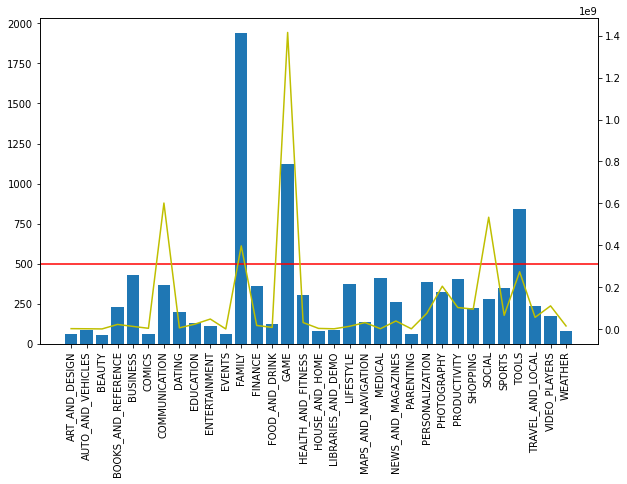

In [ ]:
cat_g = df_new.groupby('category').agg({'category': np.count_nonzero, 'reviews' : np.sum})
categ = [cat for cat, df in df_new.groupby('category')]
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax2 = ax1.twinx()
ax1.bar(categ, cat_g['category'])
ax2.plot(categ, cat_g['reviews'], color='y')
ax1.set_xticklabels(labels = categ, rotation=90)
ax1.axhline(500, color= 'red')
plt.show()

* We can see here, the categories (Family, Game, Tools) are the ones with the most apps (over 500)
* And three groups have the most reviews are (Communication, Game, Social)

## googleplaystore_user_reviews Analysis

***Data Definition***

|Column|Definition|
|:---|:---|
|App|Name of app|
|Translated_Review|User review (Preprocessed and translated to English)|
|Sentiment|Positive/Negative/Neutral (Preprocessed)|
|Sentiment_Polarity|Sentiment polarity score|
|Sentiment_Subjectivity|Sentiment subjectivity score|

In [ ]:
df_reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


### Clean up Data

In [ ]:
# Drop missing values
df_reviews = df_reviews.dropna()

In [ ]:
# Drop duplicate values
df_reviews = df_reviews.drop_duplicates()
df_reviews

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.000000,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.250000,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.400000,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.000000,0.300000
5,10 Best Foods for You,Best way,Positive,1.000000,0.300000
...,...,...,...,...,...
64222,Housing-Real Estate & Property,Most ads older many agents ..not much owner po...,Positive,0.173333,0.486667
64223,Housing-Real Estate & Property,"If photos posted portal load, fit purpose. I'm...",Positive,0.225000,0.447222
64226,Housing-Real Estate & Property,"Dumb app, I wanted post property rent give opt...",Negative,-0.287500,0.250000
64227,Housing-Real Estate & Property,I property business got link SMS happy perform...,Positive,0.800000,1.000000


### Q1: What sentiment value is the most in app reviews?

In [ ]:
df_reviews_gbSentiment = df_reviews.groupby('Sentiment').agg({'Sentiment' : np.count_nonzero})
df_reviews_gbSentiment.columns = ['Total_of_Record']
df_reviews_gbSentiment

,Total_of_Record
Sentiment,
Negative,6321
Neutral,4356
Positive,19015


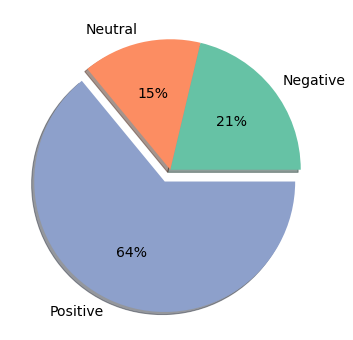

In [ ]:
my_label = [sent for sent, s in df_reviews.groupby('Sentiment')]
# define Seaborn color palette to use
palette_color = sns.color_palette('Set2')
# plotting data on chart
plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = 'sans-serif'
plt.pie(df_reviews_gbSentiment['Total_of_Record'], labels=my_label,textprops={'fontsize': 14}, colors=palette_color, autopct='%.0f%%', explode=(0,0,0.1), shadow=True)
# displaying chart
plt.show()

The pie-chart above illustrates that the Positive Sentiment has the largest value, especially 64% of the whole.

### Q2: Does "Length of Reviews" affect Sentiment_Polarity score?

In [ ]:
df_reviews = df_reviews.reset_index()
df_reviews['length_of_review'] = 0
for index, line in enumerate(df_reviews['Translated_Review']):
    # print(line, len(line), index)
    df_reviews['length_of_review'][index] = len(line)
    # print(value, index)

In [ ]:
df_reviews.head()

,index,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,length_of_review
0,0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,122
1,1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,47
2,3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,42
3,4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,12
4,5,10 Best Foods for You,Best way,Positive,1.00,0.300000,8


In [ ]:
df_reviews.describe()

,index,Sentiment_Polarity,Sentiment_Subjectivity,length_of_review
count,29692.000000,29692.000000,29692.000000,29692.000000
mean,31610.998350,0.188868,0.490930,106.895224
std,18914.545436,0.355694,0.265976,102.600246
min,0.000000,-1.000000,0.000000,2.000000
25%,13504.750000,0.000000,0.350000,30.000000
50%,31761.500000,0.157143,0.514286,79.000000
75%,48066.250000,0.422917,0.652703,153.000000
max,64230.000000,1.000000,1.000000,2713.000000


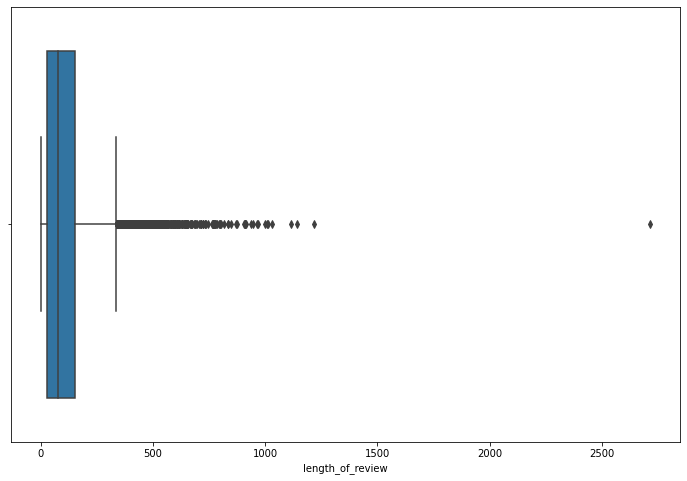

In [ ]:
plt.figure(figsize=(12, 8))
a = sns.boxplot(df_reviews['length_of_review'])

In [ ]:
df_reviews[df_reviews['length_of_review'] > 1500]

,index,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,length_of_review
12252,26472,Chrome Dev,"»TOO BRIGHT!… NIGHT MODE, PLEASE. HOW MANY REQ...",Negative,-0.077839,0.540961,2713


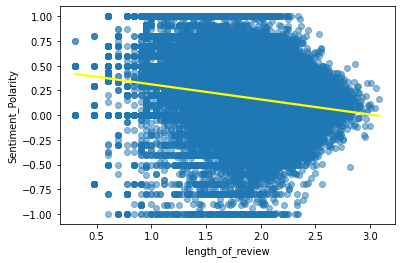

In [ ]:
df_reviews_d = df_reviews[df_reviews['length_of_review'] < 1500]
df_reviews_d['length_of_review'] = np.log10(df_reviews_d['length_of_review'])
sns.regplot(x="length_of_review", y="Sentiment_Polarity", data=df_reviews_d, fit_reg=True, scatter_kws={"alpha": 0.5}, line_kws={"color": "yellow"})

As we can see in the plot above, the regression line is slightly declined. This means that, the larger length_of_review, the smaller Sentiment_Polarity. But just a little bit.

So, in the next step, the correlation between length_of_review and Sentiment_Polarity will be measured by pearson correlation method.

The [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) (wikipedia) measures the linear association between variables. Its value can be interpreted like so:

* +1 : Complete positive correlation
* +0.8 : Strong positive correlation
* +0.6 : Moderate positive correlation
* 0 : no correlation whatsoever
* -0.6 : Moderate negative correlation
* -0.8 : Strong negative correlation
* -1 : Complete negative correlation

In [ ]:
np.corrcoef(df_reviews_d['length_of_review'], df_reviews_d['Sentiment_Polarity'])

array([[ 1.        , -0.21461524],
       [-0.21461524,  1.        ]])

The Sentiment_Polarity and the length_of_review have a weak negative linear relationship.

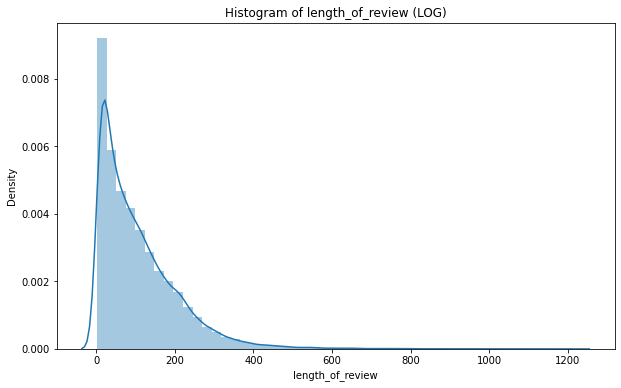

In [ ]:
fig = plt.figure(figsize=(10,6))
df_reviews_wo = df_reviews[df_reviews['length_of_review'] < 1500]
sns.distplot(df_reviews_wo["length_of_review"], kde = True, axlabel=None, bins=50).set_title("Histogram of length_of_review (LOG)")
plt.show()

* In the histogram plot above, we can see that the distribution of length_of_review is skewed to the right.

* And the plot below shows that the length_of_review in the negative group tends to be less of a smaller value.

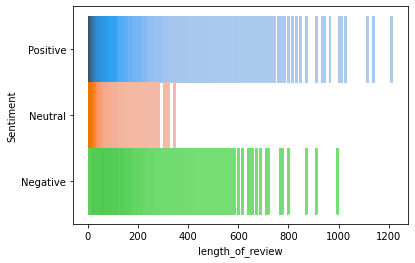

In [ ]:
sns.histplot(
    data=df_reviews_wo, x="length_of_review", y="Sentiment", hue="Sentiment", legend=False
)

### Q3: Does "Number of Reviews" each app affect Sentiment_Polarity and Sentiment_Subjectivity score?

In [ ]:
df_reviews_Q3 = df_reviews.groupby('App').agg({'Sentiment_Polarity' : np.mean, 'Sentiment_Subjectivity' : np.mean, 'App' : np.count_nonzero})
df_reviews_Q3.columns = ['Sentiment_Polarity', 'Sentiment_Subjectivity', 'total_of_reviews']
df_reviews_Q3

,Sentiment_Polarity,Sentiment_Subjectivity,total_of_reviews
App,,,
10 Best Foods for You,0.465906,0.493254,95
104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,0.358227,0.508907,36
11st,0.185943,0.455340,39
1800 Contacts - Lens Store,0.318145,0.591098,40
1LINE – One Line with One Touch,0.196290,0.557315,38
...,...,...,...
Hotels.com: Book Hotel Rooms & Find Vacation Deals,0.098559,0.525508,39
Hotspot Shield Free VPN Proxy & Wi-Fi Security,0.223750,0.380365,32
Hotstar,0.038178,0.493964,32


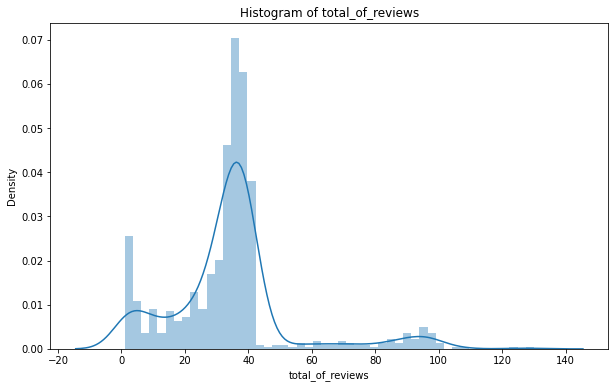

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df_reviews_Q3["total_of_reviews"], kde = True, axlabel=None).set_title("Histogram of total_of_reviews")
plt.show()

As shown in the plot above, the total of reviews in each app fall into the range of 35 to 42.

In [ ]:
a = preprocessing.minmax_scale(df_reviews_Q3, feature_range=(0, 1), axis=0, copy=True)
df_norm = pd.DataFrame(a, columns = ['Sentiment_Polarity', 'Sentiment_Subjectivity', 'total_of_reviews'])

In [ ]:
df_norm.head()

,Sentiment_Polarity,Sentiment_Subjectivity,total_of_reviews
0,0.679894,0.538095,0.728682
1,0.615357,0.555171,0.271318
2,0.512099,0.496735,0.294574
3,0.591334,0.644835,0.302326
4,0.518301,0.607980,0.286822


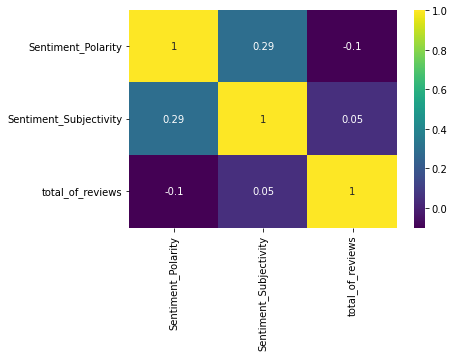

In [ ]:
sns.heatmap(df_norm.corr(),cmap='viridis',annot=True)

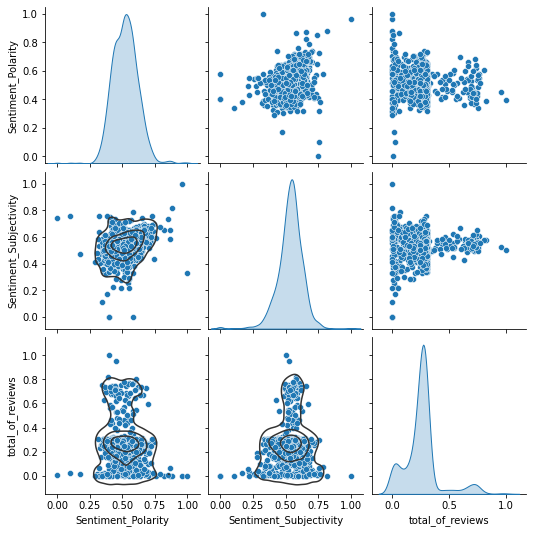

In [ ]:
s = sns.pairplot(df_norm, diag_kind="kde")
s.map_lower(sns.kdeplot, levels=4, color=".2")

Based on the constructed correlation matrix as well as the constructed visualizations, that can be demonstrated by following

*   The Sentiment_Polarity and the Sentiment_Subjectivity have a weak positive linear relationship.
*   The total_of_reviews with the Sentiment_Polarity and the Sentiment_Subjectivity have very weak correlation.

### Hypothesis testing: "Length of Reviews" and "Sentiment" ONE-WAY ANOVA Test



1.   "Sentiment" variable is defined as a factor (independent variable)
2.   "length_of_review" variable is defined as numeric (dependent variable)



We're going to test:
* H0: (μ1 = μ2 = μ3) There are no differences among 3 groups of the Sentiment. (Positive | Neural | Negative)
* H1: (μ1 ¬ μ2 ¬ μ3) There are differences among 3 groups of the Sentiment.

In [ ]:
# Drop missing values
df_reviews_wo = df_reviews_wo.dropna()

In [ ]:
df_reviews_wo.isna().sum()

index                     0
App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
length_of_review          0
dtype: int64

In [ ]:
# Drop duplicate values
df_reviews_wo = df_reviews_wo.drop_duplicates()
df_reviews_wo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29691 entries, 0 to 29691
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   29691 non-null  int64  
 1   App                     29691 non-null  object 
 2   Translated_Review       29691 non-null  object 
 3   Sentiment               29691 non-null  object 
 4   Sentiment_Polarity      29691 non-null  float64
 5   Sentiment_Subjectivity  29691 non-null  float64
 6   length_of_review        29691 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 1.8+ MB


In [ ]:
df_reviews_wo["length_of_review"] = df_reviews_wo["length_of_review"].astype(float)
df_reviews_wo["length_of_review"].min()

2.0

Taking the logarithm (log(x)) of a value effects larger values more than smaller values. 

This is useful because our data have a positive skew and it brings larger values closer to the center.

In [ ]:
df_reviews_wo["length_of_review"] = np.log(df_reviews_wo["length_of_review"])
df_reviews_wo["length_of_review"].head()

0    4.804021
1    3.850148
2    3.737670
3    2.484907
4    2.079442
Name: length_of_review, dtype: float64

#### Assumption check

Parametric tests have the same assumptions, or conditions, that need to be met in order for the analysis to be considered reliable.

1.   Independence
2.   Population distributions are normal
3.   Samples have equal variances

**Independence**

This means is that all groups are mutually exclusive, i.e. an individual can only belong in one group. Also, this means that the data is not repeated measures (not collected through time). In this example, this condition is met.

**Population distributions are normal**



One method for testing the assumption of normality is the Shapiro-Wilk test. This can be completed using the shapiro() method from scipy.stats.


In [ ]:
model = smf.ols("length_of_review ~ C(Sentiment)", data=df_reviews_wo).fit()

stats.shapiro(model.resid)

ShapiroResult(statistic=0.9655053615570068, pvalue=0.0)

The test is significant, statistic=0.5942147970199585, pvalue=0.0, which indicates that the residuals are not normally distributed.

⇒ Since normality was violated, a non-parametric statistical test was used instead.

In this case, I applied [Welch's ANOVA](https://www.statisticshowto.com/welchs-anova/).

**Welch's anova** 

The p-value (.00) from Shapiro-Wilk test is less than α = .05, which means we can reject the null hypothesis that each group has the same variance. Thus, the assumption of equal variances is violated and we can proceed to perform Welch’s ANOVA.

In [ ]:
# perform Welch's ANOVA
pg.welch_anova(dv='length_of_review', between='Sentiment', data=df_reviews_wo)

,Source,ddof1,ddof2,F,p-unc,np2
0,Sentiment,2,10539.707564,1565.391856,0.0,0.081275


The overall p-value (3.283480e-287) from the ANOVA table is less than α = .05, which means we can reject the null hypothesis

Next, I will conduct **post-hoc test** to see which Sentements significantly differ from each other;

In this case, I applied [Tukey Honestly Significant Difference (HSD)](https://methods.sagepub.com/reference/encyc-of-research-design/n478.xml) which is used to test differences among sample means for significance.

In [ ]:
comp = mc.MultiComparison(df_reviews_wo["length_of_review"], df_reviews_wo['Sentiment'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Negative,Neutral,-1.0987,0.001,-1.1496,-1.0478,True
Negative,Positive,-0.3404,0.001,-0.3779,-0.3028,True
Neutral,Positive,0.7583,0.001,0.7149,0.8017,True


**Results definition**

|Column|Definition|
|:---|:---|
|group1 and group2|the groups being compared|
|meandiff|the difference between the group means|
|p-adj|the corrected p-value which takes into account the multiple comparisons being conducted|
|lower|the lower band of the confidence interval. In the current example the confidence interval at the 95% level since α = 0.05.|
|upper|the upper band of the confidence interval. In the current example the confidence interval at the 95% level since α = 0.05.|
|reject|the decision rule based on the corrected p-value|